<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4</center></h2>

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер.

In [1]:
import time
import typing
import warnings

warnings.filterwarnings('ignore')

import tqdm
import numpy
import sympy
import pandas
import joblib
import itertools
import scipy.sparse
import sklearn.preprocessing
import tqdm.contrib.itertools
import matplotlib.pyplot as plt

In [2]:
def measure_time(func):
    start = time.time()
    res = func()
    end = time.time()
    return res, end - start

In [3]:
ratings = pandas.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pandas.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [5]:
def apk(relevant: typing.List[int], predicted: typing.List[int], k: int = 20):
    rel = numpy.isin(predicted[:k], relevant)
    pr_rel = rel * numpy.cumsum(rel) / numpy.arange(1, k + 1)
    return numpy.sum(pr_rel) / min(k, len(relevant))

def mapk(relevant: typing.List[typing.List[int]], predicted: typing.List[typing.List[int]], k: int = 20):
    return numpy.mean([ apk(*data, k) for data in zip(relevant, predicted) ])

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k = 5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm.tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pandas.concat(train_ratings).reset_index(drop = True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm.tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[numpy.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pandas.concat(test_ratings).reset_index(drop = True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

100%|██████████| 241/241 [00:00<00:00, 3707.78it/s]


Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = numpy.where(~numpy.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace = True)
tracks_info = tracks_info.reset_index(drop = True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = sklearn.preprocessing.LabelEncoder()
    iencoder = sklearn.preprocessing.LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (1 балл).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pandas.DataFrame):
        self.ratings = ratings
        self.n_users = len(numpy.unique(self.ratings['userId']))
        self.n_items = len(numpy.unique(self.ratings['trackId']))

        self.R = numpy.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: typing.List[typing.List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = numpy.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~numpy.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int):
        test_preds = [ self.recommend(uid) for uid in range(self.n_users) ]
        test_preds = self.remove_train_items(test_preds, k)
        return test_preds[test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (1 балл).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [16]:
def pearson(ratings: numpy.ndarray, user_vector: numpy.ndarray) -> numpy.ndarray:
    # Kind of weird that r_ui is a binary flag, but I am just doing what the task says...
    numer = numpy.sum((ratings > 0) & (user_vector > 0), axis = 1)
    return numer / numpy.sqrt(numpy.sum(ratings > 0, axis = 1) * numpy.sum(user_vector > 0))

def jaccard(ratings: numpy.ndarray, user_vector: numpy.ndarray) -> numpy.ndarray:
    numer = numpy.sum((ratings > 0) & (user_vector > 0), axis = 1)
    denom = numpy.sum((ratings > 0) | (user_vector > 0), axis = 1)
    return numer / denom

In [17]:
# As 'ratings' and 'user_vector' consist of only 0/1 in all tasks, let's implement these functions more efficiently
def pearson(ratings: numpy.ndarray, user_vector: numpy.ndarray) -> numpy.ndarray:
    return (ratings @ user_vector.T) / numpy.sqrt(ratings.sum(axis = 1) * user_vector.sum())

def jaccard(ratings: numpy.ndarray, user_vector: numpy.ndarray) -> numpy.ndarray:
    return (ratings @ user_vector.T) / numpy.logical_or(user_vector, ratings).sum(axis = 1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [18]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [ pearson, jaccard ]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: numpy.ndarray):
        """
        user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)

    def recommend(self, uid: int, tol: int = 1e-10):
        sim = self.similarity(self.R[uid])
        sim[uid] = self.alpha # Exclude the user from neighbours
        N = numpy.where(sim > self.alpha)[0]

        denom = numpy.maximum(numpy.sum(numpy.abs(sim[N])), tol)
        return numpy.argsort((sim[N].reshape(-1,) @ self.R[N, :]) / denom)[::-1]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

Pearson: 6.330974340438843
Jaccard: 8.166656255722046


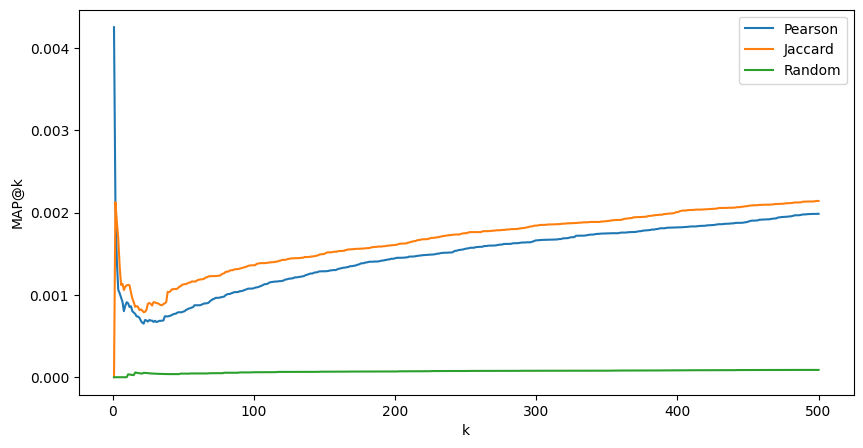

In [19]:
MAX_K = 500
numpy.random.seed(42)

pearson_model = User2User(train_ratings, pearson)
jaccard_model = User2User(train_ratings, jaccard)
random_model = BaseModel(train_ratings)

pearson_predicted, pearson_time = measure_time(lambda: pearson_model.get_test_recommendations(MAX_K))
jaccard_predicted, jaccard_time = measure_time(lambda: jaccard_model.get_test_recommendations(MAX_K))
random_predicted = numpy.random.rand(random_model.n_users, random_model.n_items).argsort(axis = 1)[:, :MAX_K]

print('Pearson:', pearson_time)
print('Jaccard:', jaccard_time)

plt.figure(figsize = (10, 5))
plt.ylabel('MAP@k')
plt.xlabel('k')

X = range(1, MAX_K + 1)
plt.plot(X, [ mapk(test_relevant, pearson_predicted, k) for k in X ], label = 'Pearson')
plt.plot(X, [ mapk(test_relevant, jaccard_predicted, k) for k in X ], label = 'Jaccard')
plt.plot(X, [ mapk(test_relevant, random_predicted, k) for k in X ], label = 'Random')
plt.legend()
plt.show()

- Качество случайных рекомендаций пренебрежимо мало отличается от нуля.
- Алгоритмы на основе User2User рекомендаций работают лучше случайных, но качество все равно близко к нулю.
- Мера Жаккара работает немного лучше корреляции Пирсона
- С увеличением $k$ величина MAP@k. ожидаемо, возрастает

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [20]:
def pearson_sparse(ratings: scipy.sparse.csr_matrix, user_vector: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    return pearson(ratings, user_vector) # Initial function works with sparse matrices

def jaccard_sparse(ratings: scipy.sparse.csr_matrix, user_vector: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    denom = scipy.sparse.vstack([ user_vector for _ in range(ratings.shape[0]) ])
    denom = (denom.astype('bool') + ratings.astype('bool')).sum(axis = 1)
    return (ratings @ user_vector.T) / denom

In [21]:
class User2UserSparse(User2User):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings, pearson)

        assert similarity_func in [ pearson_sparse, jaccard_sparse ]
        self.similarity_func = similarity_func
        
        self.R = scipy.sparse.csr_matrix(self.R)
        
    def similarity(self, user_vector: numpy.ndarray):
        return self.similarity_func(self.R, user_vector).toarray()

Pearson: 0.8119587898254395
Jaccard: 1.3515872955322266


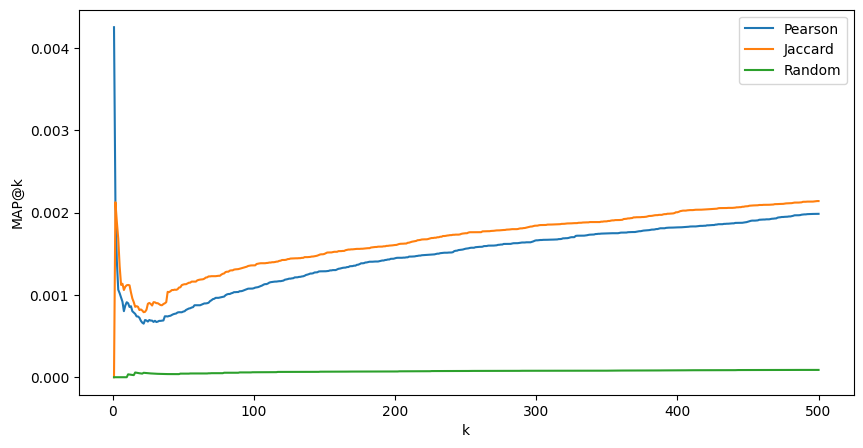

In [22]:
numpy.random.seed(42)

pearson_sparse_model = User2UserSparse(train_ratings, pearson_sparse)
jaccard_sparse_model = User2UserSparse(train_ratings, jaccard_sparse)
random_sparse_model = BaseModel(train_ratings)

pearson_sparse_predicted, pearson_sparse_time = measure_time(lambda: pearson_sparse_model.get_test_recommendations(MAX_K))
jaccard_sparse_predicted, jaccard_sparse_time = measure_time(lambda: jaccard_sparse_model.get_test_recommendations(MAX_K))
random_sparse_predicted = numpy.random.rand(random_sparse_model.n_users, random_sparse_model.n_items).argsort(axis = 1)[:, :MAX_K]

print('Pearson:', pearson_sparse_time)
print('Jaccard:', jaccard_sparse_time)

plt.figure(figsize = (10, 5))
plt.ylabel('MAP@k')
plt.xlabel('k')

X = range(1, MAX_K + 1)
plt.plot(X, [ mapk(test_relevant, pearson_sparse_predicted, k) for k in X ], label = 'Pearson')
plt.plot(X, [ mapk(test_relevant, jaccard_sparse_predicted, k) for k in X ], label = 'Jaccard')
plt.plot(X, [ mapk(test_relevant, random_sparse_predicted, k) for k in X ], label = 'Random')
plt.legend()
plt.show()

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [23]:
numpy.random.seed(0)
user_id = numpy.random.randint(0, jaccard_sparse_model.n_users)

listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]
display(tracks_info.loc[listened_tracks][['name', 'artists']])

,name,artists
152,Hollywood Whore,['Papa Roach']
164,My Favourite Game,['The Cardigans']
199,Don't Phunk With My Heart,['Black Eyed Peas']
212,Let's Get It Started,['Black Eyed Peas']
234,Wind Of Change,['Scorpions']
344,Somebody Told Me,['The Killers']
396,The Phantom Of The Opera,"['Nightwish', 'Andrew Lloyd Webber']"
422,Stan,"['Eminem', 'Dido']"
464,Tainted Love,['Marilyn Manson']
630,Every Breath You Take,['The Police']


In [24]:
preds = jaccard_sparse_model.get_test_recommendations(15)
display(tracks_info.loc[preds[user_id]][['name', 'artists']])

,name,artists
34418,Драмы больше нет,['Полина Гагарина']
39455,Drunk Groove,"['MARUV', 'Boosin']"
44188,Мокрые кроссы,['Тима Белорусских']
46279,"Мама, я танцую",['#2Маши']
11493,The Show Must Go On,['Queen']
5810,Так же как все,"[""A'Studio""]"
49023,Грустный дэнс,"['Artik & Asti', 'Артём Качер']"
4765,Last Night,"['P. Diddy', 'Keyshia Cole']"
16829,Love Bites,['Def Leppard']
46042,Время Ток,['Антоха МС']


In [25]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]
display(tracks_info.loc[test_tracks][['name', 'artists']])

,name,artists
63988,If You Love Me,"['Мари Краймбрери', 'Alex Davia']"
64325,Кхуям,['Хитобои']
64568,таблетки,['Земфира']
64574,жди меня,['Земфира']
64576,крым,['Земфира']
64675,ZITTI E BUONI,['Måneskin']
64682,CORALINE,['Måneskin']
64683,I WANNA BE YOUR SLAVE,['Måneskin']
64743,Dernière Danse,"['Yves V', 'Shanguy', 'Axel Cooper']"
65142,Я никогда не стану феминисткой,['Nodahsa']


Кажется, получилось достаточно плохо

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**LFM:**

Из лекции: \
 \
![Alternative Text][1717696476395]

[1717696476395]: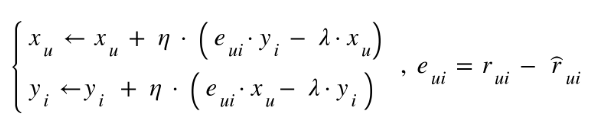

Убедимся, что они работают:

In [26]:
# r_ii is a number
R = sympy.Matrix([
    [ sympy.S('r11'), sympy.S('r12'), sympy.S('r13'), sympy.S('r14') ],
    [ sympy.S('r21'), sympy.S('r22'), sympy.S('r23'), sympy.S('r24') ],
    [ sympy.S('r31'), sympy.S('r32'), sympy.S('r33'), sympy.S('r34') ]
])

# p_i is a vector
P = sympy.Matrix([
    [ sympy.S('p1') ],
    [ sympy.S('p2') ],
    [ sympy.S('p3') ]
])

# q_i is a vector
Q = sympy.Matrix([
    [ sympy.S('q1'), sympy.S('q2'), sympy.S('q3'), sympy.S('q4') ]
])

lamb = sympy.Symbol('lambda')

def square(M: sympy.Matrix):
    return M.applyfunc(lambda i: i ** 2)

loss = sum(square(P @ Q - R)) + lamb * (sum(square(P)) + sum(square(Q)))

display(sympy.diff(loss, sympy.S('p2')))
display(2 * ((P @ Q - R) @ Q.T + lamb * P))

display(sympy.diff(loss, sympy.S('q2')))
display(2 * (P.T @ (P @ Q - R) + lamb * Q).T)

2*lambda*p2 + 2*q1*(p2*q1 - r21) + 2*q2*(p2*q2 - r22) + 2*q3*(p2*q3 - r23) + 2*q4*(p2*q4 - r24)

Matrix([
[2*lambda*p1 + 2*q1*(p1*q1 - r11) + 2*q2*(p1*q2 - r12) + 2*q3*(p1*q3 - r13) + 2*q4*(p1*q4 - r14)],
[2*lambda*p2 + 2*q1*(p2*q1 - r21) + 2*q2*(p2*q2 - r22) + 2*q3*(p2*q3 - r23) + 2*q4*(p2*q4 - r24)],
[2*lambda*p3 + 2*q1*(p3*q1 - r31) + 2*q2*(p3*q2 - r32) + 2*q3*(p3*q3 - r33) + 2*q4*(p3*q4 - r34)]])

2*lambda*q2 + 2*p1*(p1*q2 - r12) + 2*p2*(p2*q2 - r22) + 2*p3*(p3*q2 - r32)

Matrix([
[2*lambda*q1 + 2*p1*(p1*q1 - r11) + 2*p2*(p2*q1 - r21) + 2*p3*(p3*q1 - r31)],
[2*lambda*q2 + 2*p1*(p1*q2 - r12) + 2*p2*(p2*q2 - r22) + 2*p3*(p3*q2 - r32)],
[2*lambda*q3 + 2*p1*(p1*q3 - r13) + 2*p2*(p2*q3 - r23) + 2*p3*(p3*q3 - r33)],
[2*lambda*q4 + 2*p1*(p1*q4 - r14) + 2*p2*(p2*q4 - r24) + 2*p3*(p3*q4 - r34)]])

**ALS:**

$R = P * Q + \epsilon$

Формулы обновления параметров те же. Меняется только способ их изменения: не одновременно, а последовательно на разных итерациях. \
При этом на каждой итерации фактически решается задача линейной регрессии:

<b><u>При заморозке Q и обновлении P</u></b> \
<b>Решаемая задача:</b> \
$R \approx P * Q$ \
<b>Аналитическое решение:</b> \
$Q = (P^T * P)^{-1} * P^T * R$

<b><u>При заморозке P и обновлении Q</u></b> \
<b>Решаемая задача:</b> \
$R \approx P * Q$ \
$R^T \approx (P * Q)^T$ \
$R^T \approx Q^T * P^T$ \
<b>Аналитическое решение:</b> \
$P^T = ((Q^T)^T * (Q^T))^{-1} * (Q^T)^T * R^T$ \
$P^T = (Q * Q^T)^{-1} * Q * R^T$ \
$P = ((Q * Q^T)^{-1} * Q * R^T)^T$ \
$P = (R^T)^T * (Q)^T * ((Q * Q^T)^{-1})^T$ \
$P = R * Q^T * ((Q * Q^T)^T)^{-1}$ \
$P = R * Q^T * ((Q^T)^T * Q^T)^{-1}$ \
$P = R * Q^T * (Q * Q^T)^{-1}$

**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [332]:
def loss(P: numpy.ndarray, Q: numpy.ndarray, lamb: float):
    return numpy.sum((P @ Q - R) ** 2) + lamb * (numpy.sum(P ** 2) + numpy.sum(Q ** 2))

class HiddenVarBaseModel(BaseModel):
    def __init__(self, ratings: pandas.DataFrame, dim: int = 128, num_iters: int = 5):
        super().__init__(ratings)
        self.num_iters = num_iters
        self.P = numpy.random.normal(size = (self.n_users, dim))
        self.Q = numpy.random.normal(size = (dim, self.n_items))

    def fit(self):
        raise NotImplementedError

    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q
        return numpy.argsort(pred_rating)[::-1]
    
class LFMModel(HiddenVarBaseModel):
    def __init__(self, ratings: pandas.DataFrame, dim: int = 128, num_iters: int = 5, lr: float = 0.0003, lamb: float = 0.01):
        super().__init__(ratings, dim, num_iters)
        self.lamb = lamb
        self.lr = lr

    def fit(self):
        for _ in range(self.num_iters):
            grad_P = 2 * ((self.P @ self.Q - self.R) @ self.Q.T + self.lamb * self.P)
            grad_Q = 2 * (self.P.T @ (self.P @ self.Q - self.R) + self.lamb * self.Q)
            self.P = self.P - self.lr * grad_P
            self.Q = self.Q - self.lr * grad_Q
        return self
    
class ALSModel(HiddenVarBaseModel):
    def fit(self):
        for epoch in range(self.num_iters):
            if epoch % 2 == 0: self.Q = numpy.linalg.inv(self.P.T @ self.P) @ self.P.T @ self.R
            else: self.P = self.R @ self.Q.T @ numpy.linalg.inv(self.Q @ self.Q.T)
        return self

LFM: 1.4623322486877441
ALS: 1.195004940032959


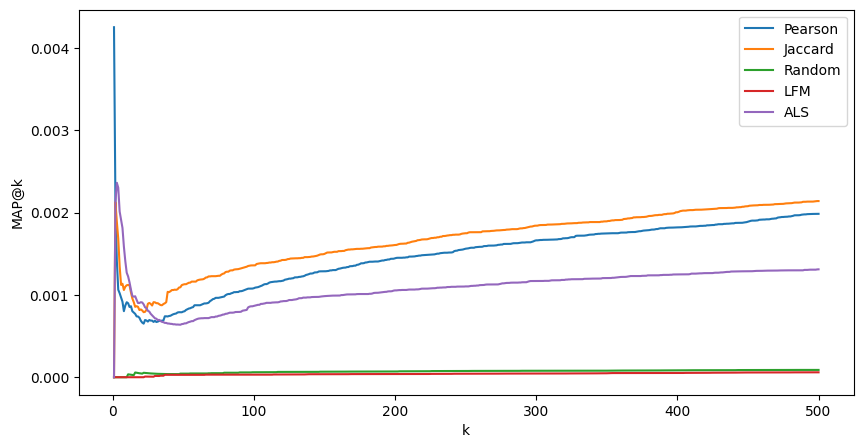

In [28]:
numpy.random.seed(42)

lfm_model = LFMModel(train_ratings).fit()
als_model = ALSModel(train_ratings).fit()

lfm_predicted, lfm_time = measure_time(lambda: lfm_model.get_test_recommendations(MAX_K))
als_predicted, als_time = measure_time(lambda: als_model.get_test_recommendations(MAX_K))

print('LFM:', lfm_time)
print('ALS:', als_time)

plt.figure(figsize = (10, 5))
plt.ylabel('MAP@k')
plt.xlabel('k')

X = range(1, MAX_K + 1)
plt.plot(X, [ mapk(test_relevant, pearson_sparse_predicted, k) for k in X ], label = 'Pearson')
plt.plot(X, [ mapk(test_relevant, jaccard_sparse_predicted, k) for k in X ], label = 'Jaccard')
plt.plot(X, [ mapk(test_relevant, random_sparse_predicted, k) for k in X ], label = 'Random')
plt.plot(X, [ mapk(test_relevant, lfm_predicted, k) for k in X ], label = 'LFM')
plt.plot(X, [ mapk(test_relevant, als_predicted, k) for k in X ], label = 'ALS')
plt.legend()
plt.show()

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [333]:
def try_params(model_class, params):
    numpy.random.seed(42)
    model = model_class(train_ratings, *params).fit()
    predictions = model.get_test_recommendations(MAX_K)
    scores = numpy.array([ mapk(test_relevant, predictions, k) for k in range(1, MAX_K + 1) ])
    return [
        { 'params': params, 'k': f'1 - {MAX_K}', 'auc': ((scores[:-1] + scores[1:]) / 2).sum() },
        *[ { 'params': params, 'k': k + 1, 'mapk': score } for k, score in enumerate(scores) ]
    ]

In [83]:
lfm_results = joblib.Parallel(n_jobs = -1)(
    joblib.delayed(try_params)(LFMModel, params)
    for params in tqdm.contrib.itertools.product(
        [ 32, 64, 128, 256, 512 ],
        range(5, 46, 10),
        [ 3e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6 ],
        [ 1, 0.5, 0.25, 0.1, 0.05, 0.01 ]
    )
)
lfm_results = pandas.DataFrame(list(itertools.chain(*lfm_results)))
# Let's choose parameters by area under mapk@k curve: all predictions should be reasonable, not only for small k's
lfm_results.sort_values(by = 'auc', ascending = False).head(20) 

  0%|          | 0/900 [00:00<?, ?it/s]

,params,k,auc,mapk
397293,"(512, 25, 0.0003, 0.5)",1 - 500,0.355321,NaN
405309,"(512, 25, 5e-05, 0.01)",1 - 500,0.355321,NaN
252504,"(128, 45, 0.0003, 1)",1 - 500,0.355321,NaN
134769,"(64, 25, 5e-05, 0.01)",1 - 500,0.355321,NaN
134268,"(64, 25, 5e-05, 0.05)",1 - 500,0.355321,NaN
133767,"(64, 25, 5e-05, 0.1)",1 - 500,0.355321,NaN
133266,"(64, 25, 5e-05, 0.25)",1 - 500,0.355321,NaN
132765,"(64, 25, 5e-05, 0.5)",1 - 500,0.355321,NaN
132264,"(64, 25, 5e-05, 1)",1 - 500,0.355321,NaN
131763,"(64, 25, 0.0001, 0.01)",1 - 500,0.355321,NaN


In [334]:
def f(size):
    numpy.random.seed(42)
    return numpy.linalg.inv(numpy.random.normal(size = (size, size)))
print((joblib.Parallel(n_jobs = 2)(joblib.delayed(f)(p) for p in [ 10 ])[0] == f(10)).all())
print((joblib.Parallel(n_jobs = 2)(joblib.delayed(f)(p) for p in [ 12 ])[0] == f(12)).all())
print((joblib.Parallel(n_jobs = 2)(joblib.delayed(f)(p) for p in [ 15 ])[0] == f(15)).all())

True
False
False


In [340]:
# numpy.linalg.inv gives incorrect results when used with joblib for big matrices (see cell above).
# Took me 3 hours to debug 😭
# Thus, ALS cannot run in parallel :(
als_results = [ ]
for params in tqdm.contrib.itertools.product([ 32, 64, 128, 256, 512 ], range(1, 75)):
    als_results.append(try_params(ALSModel, params))
als_results = pandas.DataFrame(list(itertools.chain(*als_results)))
als_results.sort_values(by = 'auc', ascending = False).head(20)

  0%|          | 0/370 [00:00<?, ?it/s]

,params,k,auc,mapk
44589,"(64, 16)",1 - 500,1.065468,NaN
51102,"(64, 29)",1 - 500,1.063036,NaN
43086,"(64, 13)",1 - 500,1.055912,NaN
45591,"(64, 18)",1 - 500,1.052359,NaN
59118,"(64, 45)",1 - 500,1.051758,NaN
73146,"(64, 73)",1 - 500,1.045959,NaN
59619,"(64, 46)",1 - 500,1.045492,NaN
72144,"(64, 71)",1 - 500,1.045348,NaN
60120,"(64, 47)",1 - 500,1.044251,NaN
52104,"(64, 31)",1 - 500,1.043420,NaN


Train LFM: 17.678871631622314
Train ALS: 0.3888683319091797
Best LFM: 1.5506772994995117
Best ALS: 1.0411880016326904


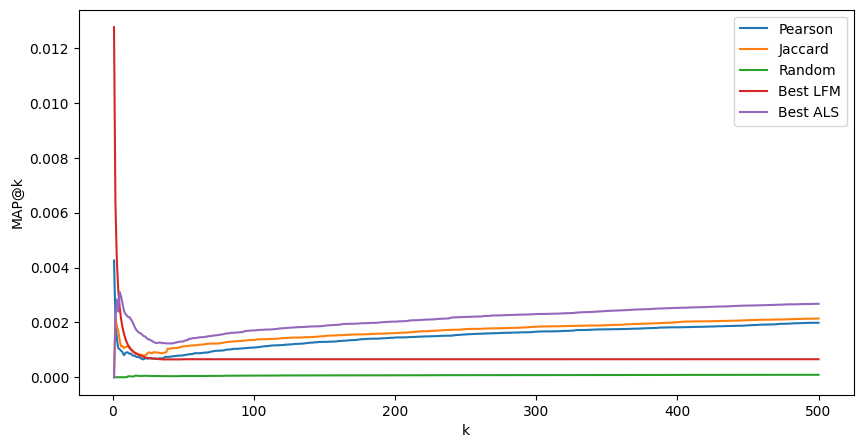

In [341]:
numpy.random.seed(42)
best_lfm_model, lfm_train_ime = measure_time(lambda: LFMModel(train_ratings, 512, 25, 0.0003, 0.5).fit())
print('Train LFM:', lfm_train_ime)

numpy.random.seed(42)
best_als_model, als_train_ime = measure_time(lambda: ALSModel(train_ratings, 64, 16).fit())
print('Train ALS:', als_train_ime)

best_lfm_predicted, best_lfm_time = measure_time(lambda: best_lfm_model.get_test_recommendations(MAX_K))
best_als_predicted, best_als_time = measure_time(lambda: best_als_model.get_test_recommendations(MAX_K))

print('Best LFM:', best_lfm_time)
print('Best ALS:', best_als_time)

plt.figure(figsize = (10, 5))
plt.ylabel('MAP@k')
plt.xlabel('k')

X = range(1, MAX_K + 1)
plt.plot(X, [ mapk(test_relevant, pearson_sparse_predicted, k) for k in X ], label = 'Pearson')
plt.plot(X, [ mapk(test_relevant, jaccard_sparse_predicted, k) for k in X ], label = 'Jaccard')
plt.plot(X, [ mapk(test_relevant, random_sparse_predicted, k) for k in X ], label = 'Random')
plt.plot(X, [ mapk(test_relevant, best_lfm_predicted, k) for k in X ], label = 'Best LFM')
plt.plot(X, [ mapk(test_relevant, best_als_predicted, k) for k in X ], label = 'Best ALS')
plt.legend()
plt.show()

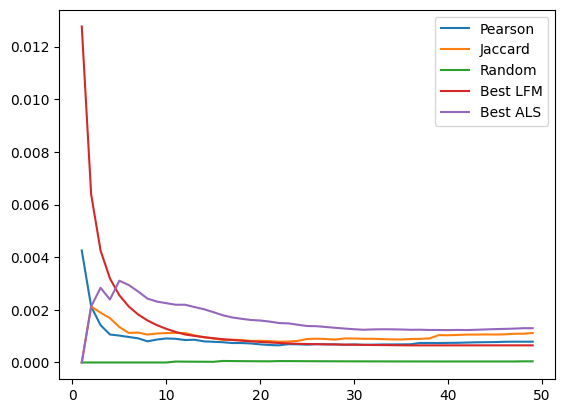

In [342]:
X = range(1, 50)
plt.plot(X, [ mapk(test_relevant, pearson_sparse_predicted, k) for k in X ], label = 'Pearson')
plt.plot(X, [ mapk(test_relevant, jaccard_sparse_predicted, k) for k in X ], label = 'Jaccard')
plt.plot(X, [ mapk(test_relevant, random_sparse_predicted, k) for k in X ], label = 'Random')
plt.plot(X, [ mapk(test_relevant, best_lfm_predicted, k) for k in X ], label = 'Best LFM')
plt.plot(X, [ mapk(test_relevant, best_als_predicted, k) for k in X ], label = 'Best ALS')
plt.legend()
plt.show()

LFM показал хороший результат при маленьких $k$, но наблюдается стремительное ухудшение рекомендаций по мере увеличения $k$. ALS же напротив показывает себя хуже даже User2User-моделей при маленьких $k$, но качество рекомендаций растёт при рассмотрении большего числа треков. \
В целом, обучение LFM оказалось достаточно сложной задачей как с точки зрения подбора гиперпараметров, так и с точки зрения необходимых вычислительных ресурсов. \
С числом итераций обучения качество, ожидаемо, сначала увеличивается, а затем начинает падать из-за переобучения. Как видно из полученных результатов, для LFM оптимально около 25 итераций, а ALS показывает хорошие результаты для значений от 15 до 50. \
Для данной задачи наиболее подходящим мне кажется алгоритм ALS, который работает достаточно быстро и обучается сравниетельно легко, достигая при этом хороших результатов.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [343]:
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = best_als_model.Q.T @ best_als_model.Q.T[example_trackId]
preds = preds / numpy.sqrt((best_als_model.Q.T ** 2).sum(axis = 1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [344]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / numpy.linalg.norm(best_als_model.Q.T[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
2058,Последний герой,['КИНО'],0.718018
16192,Однажды мир прогнётся под нас,['Машина времени'],0.656794
2179,Восьмиклассница,['КИНО'],0.643966
14871,Никто не услышит (Ой-йо),['ЧайФ'],0.628658
13263,Мусорный ветер,['Крематорий'],0.626923
13264,Безобразная Эльза,['Крематорий'],0.626923
9876,Wake Up,['Cheese People'],0.564177
7753,Nantes,['Barbara'],0.564177
1039,Get Up I Feel Like Being A Sex Machine,['James Brown'],0.564177
